In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

columns = ["id", "diagnosis"]
x_columns = []
for i in range(1, 31):
    columns.append("feature_" + str(i))
    x_columns.append("feature_" + str(i))

df = pd.read_csv("data/wdbc.data", names=columns)

## Data preprocessing
Apply MinMaxScaler to the features to minimize the effect of features with large values

In [107]:
features = df[x_columns]
features = MinMaxScaler().fit_transform(features)

target = df["diagnosis"]
target = target.map({"M": 1, "B": 0})

## K-Means implementation

In [108]:
def k_means(data, k, max_iters=100):
    cent = data[np.random.choice(data.shape[0], k, replace=False)]
    
    label = np.array([])
    
    for _ in range(max_iters):
        # Step 2: Assign data points to clusters
        distances = np.sqrt(((data - cent[:, np.newaxis]) ** 2).sum(axis=2))
        label = np.argmin(distances, axis=0)

        # Step 3: Update centroids
        new_centroids = np.array([data[label == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.allclose(cent, new_centroids):
            break

        cent = new_centroids

    return cent, label

In [109]:
def calculate_accuracy(l, t):
    acc = np.mean(l == t)
    if acc < 0.5:
        acc = 1 - acc

    return acc

## Elbow method

In [118]:
def elbow_method(data, max_k=10):
    sum_squared_err = []

    for current_k in range(1, max_k + 1):
        centroids, labels = k_means(data, k=current_k)
        sum_squared_err.append(np.sum((data - centroids[labels]) ** 2))

    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_k + 1), sum_squared_err, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow')
    plt.grid()
    plt.show()

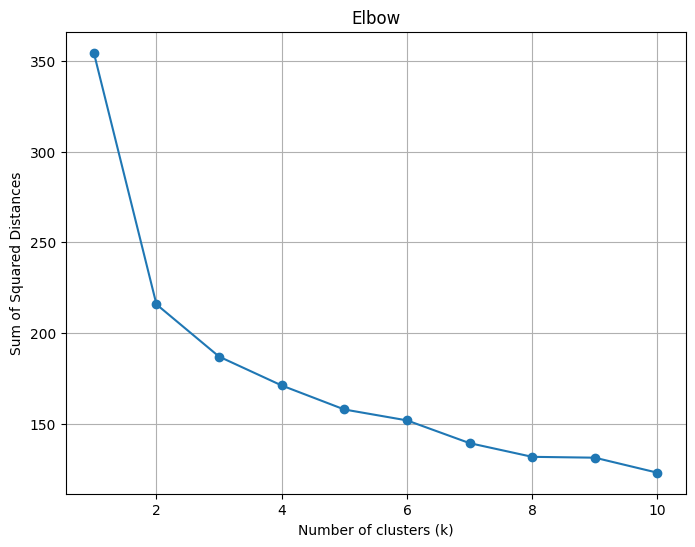

In [119]:
elbow_method(features)

## Observations
We can see that the elbow is at k=2, which is the number of classes in the dataset.

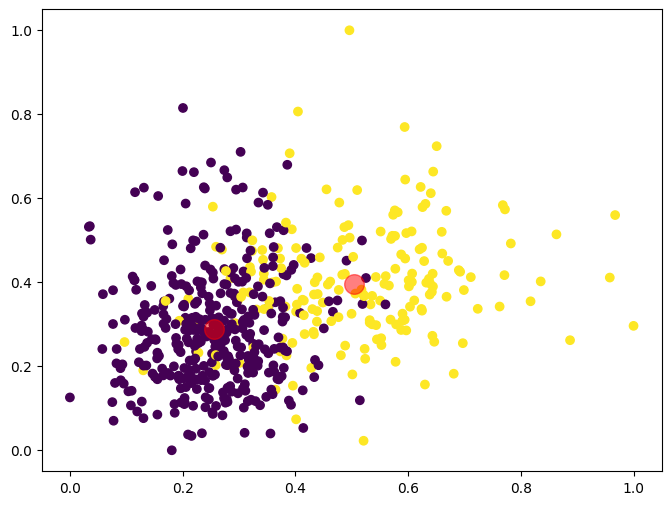

Accuracy: 92.79%


In [111]:
centroids, labels = k_means(features, k=2)

# plt
plt.figure(figsize=(8, 6))
plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.5)
plt.show()

# Calculate accuracy
accuracy = calculate_accuracy(labels, target)

print("Accuracy: " + str(round(accuracy * 100, 2)) + "%")

sse_exp_1 = np.sum((features - centroids[labels]) ** 2) 

# PCA implementation

In [112]:
def pca(data, num_components):
    # Step 1: Standardize the data
    data_mean = np.mean(data, axis=0)
    standardized_data = data - data_mean

    # Step 2: Compute the covariance matrix
    covariance_matrix = np.cov(standardized_data, rowvar=False)

    # Step 3: Calculate eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Step 4: Select top k eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    top_k_indices = sorted_indices[:num_components]
    principal_components = eigenvectors[:, top_k_indices]

    # Step 5: Project the data onto the selected principal components
    transformed_data = np.dot(standardized_data, principal_components)

    return transformed_data

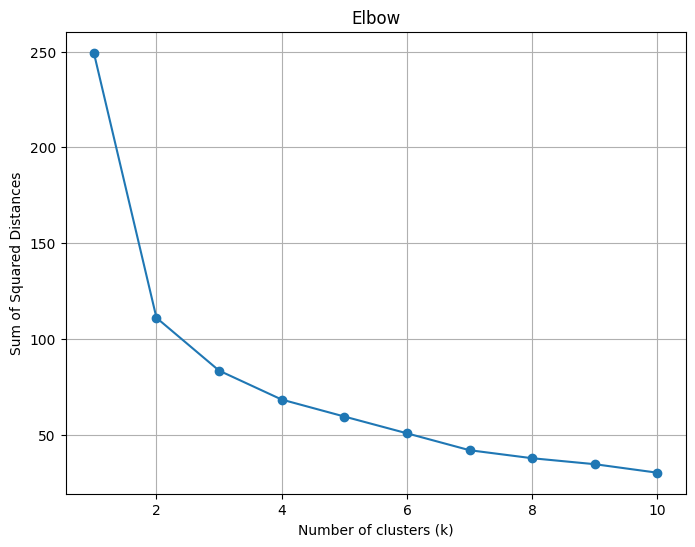

In [113]:
t_data = pca(features, num_components=2)

elbow_method(t_data)

In [114]:
k = 2
centroids, labels = k_means(t_data, k)

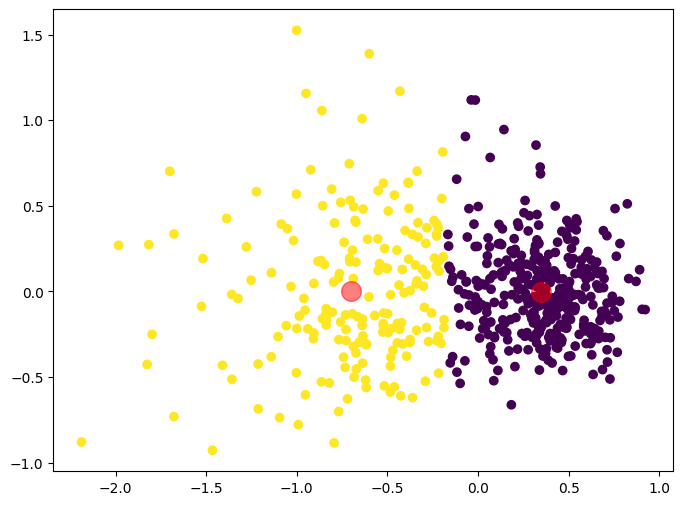

Accuracy: 92.79%


In [115]:
plt.figure(figsize=(8, 6))
plt.scatter(t_data[:, 0], t_data[:, 1], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, alpha=0.5)
plt.show()

sse_exp_2 = np.sum((t_data - centroids[labels]) ** 2)

accuracy = calculate_accuracy(labels, target)
print("Accuracy: " + str(round(accuracy * 100, 2)) + "%")

# Comparing Sum of Squared error
## Expectations
### Experiment 1 (Without PCA):
- SSE reflects distances in the original feature space without dimensionality reduction.
- Higher SSE may indicate more scattered or dispersed clusters due to the higher dimensionality.

### Experiment 2 (With PCA):
- Lower SSE compared to Experiment 1 due to dimensionality reduction.
- PCA attempts to retain the most relevant information in fewer dimensions.
- Lower SSE suggests that clustering in a reduced-dimensional space captures the inherent structure better.

In [116]:
print(f"SSE Experiment 1 (Without PCA): {round(sse_exp_1, 2)}")
print(f"SSE Experiment 2 (With PCA): {round(sse_exp_2, 2)}")

SSE Experiment 1 (Without PCA): 215.84
SSE Experiment 2 (With PCA): 110.97


## Trying different principale components

Accuracy with 2 Components: 92.79%
Accuracy with 3 Components: 92.79%
Accuracy with 4 Components: 92.79%
Accuracy with 6 Components: 92.79%
Accuracy with 8 Components: 92.79%


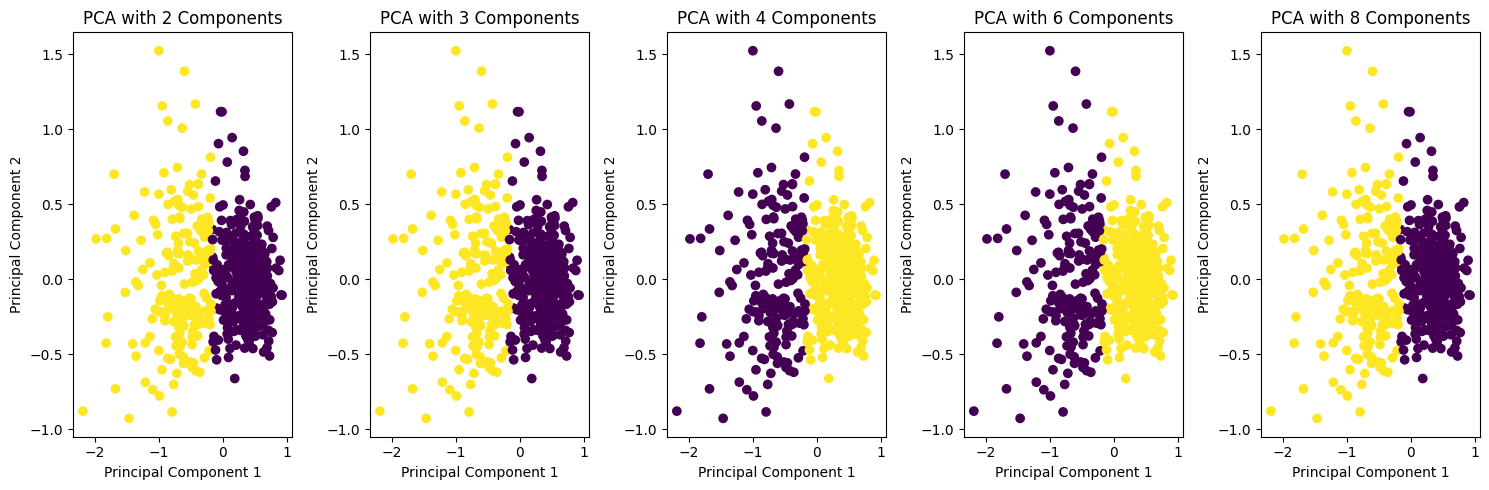

In [117]:
num_components_list = [2, 3, 4, 6, 8]

fig, axs = plt.subplots(1, len(num_components_list), figsize=(15, 5))

for idx, n_components in enumerate(num_components_list):
    t_data = pca(features, n_components)

    centroids, labels = k_means(t_data, k=2)
    
    ax = axs[idx] if len(num_components_list) > 1 else axs
    ax.scatter(t_data[:, 0], t_data[:, 1], c=labels, cmap='viridis')
    ax.set_title(f'PCA with {n_components} Components')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    
    accuracy = calculate_accuracy(labels, target)
    print(f"Accuracy with {n_components} Components: {str(round(accuracy * 100, 2))}%")

plt.tight_layout()
plt.show()